<a href="https://colab.research.google.com/github/bonnefco/P8/blob/main/P8_BERT_CONCAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importation des librairies

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn
import ast
from scipy import stats
import tensorflow
from sklearn.model_selection import train_test_split
import os
import glob

In [ ]:
import transformers

from transformers import TFAutoModel, AutoConfig, DistilBertTokenizer

In [ ]:
tensorflow.keras.backend.clear_session()

# Fonctions

In [ ]:
def plot_curves(history):

    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    plt.show()

    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("model loss")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "valid"], loc="upper left")
    plt.show()

    return

# Importation du dataset

In [ ]:
df_effective_args = pd.read_csv(
    "../input/feedback-prize-effectiveness/train.csv", header=(0)
)

## Lier chaque discourse_id avec le texte integrale

In [ ]:
def create_dict_key_id___value_essay_text(path_folder):

    list_texts_essay = glob.glob(path_folder + "/*")
    dictionnary = {}
    for text in list_texts_essay:
        essay_text = open(text, "r").read()
        id_essay = text.split("/")[-1].split(".")[0]
        dictionnary[id_essay] = essay_text

    return dictionnary


def df_link_essay_id_and_text_essay(df, path_folder):
    dictionnary_key_id___value_essay_text = create_dict_key_id___value_essay_text(
        path_folder
    )
    df["essay_text"] = df["essay_id"].map(dictionnary_key_id___value_essay_text)
    return df

In [ ]:
path_train_folder = "../input/feedback-prize-effectiveness/train"
df_effective_args = df_link_essay_id_and_text_essay(
    df_effective_args, path_train_folder
)

In [ ]:
df_effective_args.head(2)

,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"Hi, i'm Isaac, i'm going to be writing about h...",Lead,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"On my perspective, I think that the face is a ...",Position,Adequate,"Hi, i'm Isaac, i'm going to be writing about h..."


# Nettoyage 

## Suppression incohérence du dataset

In [ ]:
# doublons possèdent deux "discourse_effectiveness" différents
df_duplicates = df_effective_args[
    df_effective_args.duplicated(subset=["discourse_text"], keep=False)
]
df_duplicates_different_discourse_effectiveness = df_duplicates[
    ~df_duplicates.duplicated(
        subset=["discourse_text", "discourse_effectiveness"], keep=False
    )
]
list_index_to_drop = (
    df_duplicates_different_discourse_effectiveness.index.values.tolist()
)

# doublons possèdent deux "discourse_type" différents
df_duplicates_different_discourse_type = df_duplicates[
    ~df_duplicates.duplicated(subset=["discourse_text", "discourse_type"], keep=False)
]
list_index_to_drop += df_duplicates_different_discourse_type.index.values.tolist()
df_without_incoherence = df_effective_args.drop(list_index_to_drop, axis=0)

# Conservation d'un doublon sur deux
df_effective_args_without_duplicates = df_without_incoherence.drop_duplicates(
    subset=["discourse_text"], keep="first"
)

## Passage en minuscule

In [ ]:
df_effective_args_without_duplicates[
    "essay_text"
] = df_effective_args_without_duplicates["essay_text"].str.lower()
df_effective_args_without_duplicates[
    "discourse_text"
] = df_effective_args_without_duplicates["discourse_text"].str.lower()
df_effective_args_without_duplicates.head(3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,discourse_id,essay_id,discourse_text,discourse_type,discourse_effectiveness,essay_text
0,0013cc385424,007ACE74B050,"hi, i'm isaac, i'm going to be writing about h...",Lead,Adequate,"hi, i'm isaac, i'm going to be writing about h..."
1,9704a709b505,007ACE74B050,"on my perspective, i think that the face is a ...",Position,Adequate,"hi, i'm isaac, i'm going to be writing about h..."
2,c22adee811b6,007ACE74B050,i think that the face is a natural landform be...,Claim,Adequate,"hi, i'm isaac, i'm going to be writing about h..."


## Configs et tokenizer

In [ ]:
MODEL_NAME = "../input/distilbert"
tokenizer_BERT = transformers.DistilBertTokenizer.from_pretrained(
    MODEL_NAME,
    local_files_only=True,
    pad_token="[PAD]",
    max_length=512,
    truncation=True,
)
SEP = tokenizer_BERT.sep_token

## Concatenation discourse_type [SEP] discours_text [SEP] essay_text

In [ ]:
df_effective_args_without_duplicates["type_discourse_essay_concat"] = (
    df_effective_args_without_duplicates["discourse_type"]
    + SEP
    + df_effective_args_without_duplicates["discourse_text"]
    + SEP
    + df_effective_args_without_duplicates["essay_text"]
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_effective_args_without_duplicates[
    "discourse_effectiveness_number"
] = df_effective_args["discourse_effectiveness"].replace(
    {"Ineffective": 0, "Adequate": 1, "Effective": 2}
)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_effective_args_without_duplicates.shape

(36677, 8)

In [ ]:
def bert_encode(texts, tokenizer=tokenizer_BERT):

    token = tokenizer(
        texts,
        max_length=MAX_LEN,
        truncation=True,
        padding="max_length",
        add_special_tokens=True,
        return_tensors="tf",
    )

    input_ids = token["input_ids"]
    attention_mask = token["attention_mask"]

    return input_ids[0], attention_mask[0]

# Creation modele

## Hyper-paramètres

In [ ]:
# Configuration
BATCH_SIZE = 16
DROPOUT = 0.1
LEARNING_RATE = 3e-5
MAX_LEN = 512

In [ ]:
X = df_effective_args_without_duplicates["type_discourse_essay_concat"]
y = df_effective_args_without_duplicates["discourse_effectiveness_number"]

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)
y_train = list(y_train)
y_valid = list(y_valid)


X_train = X_train.transform(bert_encode)
X_valid = X_valid.transform(bert_encode)
X_train_words_encoded, X_train_mask = zip(*X_train)
X_valid_words_encoded, X_valid_mask = zip(*X_valid)

2022-08-10 14:55:20.210589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:55:20.352342: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:55:20.356447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-10 14:55:20.361646: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Dataset Valid

In [ ]:
valid_input_words_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (list(X_valid_words_encoded))
).batch(BATCH_SIZE)


valid_input_mask_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (list(X_valid_mask))
).batch(BATCH_SIZE)

valid_output_dataset = tensorflow.data.Dataset.from_tensor_slices((y_valid)).batch(
    BATCH_SIZE
)

data_valid_words_mask = tensorflow.data.Dataset.zip(
    (valid_input_words_dataset, valid_input_mask_dataset)
)
data_valid = tensorflow.data.Dataset.zip((data_valid_words_mask, valid_output_dataset))
print(data_valid.element_spec)

((TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


Dataset train

In [ ]:
train_input_words_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (list(X_train_words_encoded))
).batch(BATCH_SIZE)


train_input_mask_dataset = tensorflow.data.Dataset.from_tensor_slices(
    (list(X_train_mask))
).batch(BATCH_SIZE)

train_output_dataset = tensorflow.data.Dataset.from_tensor_slices((y_train)).batch(
    BATCH_SIZE
)

data_train_words_mask = tensorflow.data.Dataset.zip(
    (train_input_words_dataset, train_input_mask_dataset)
)
data_train = tensorflow.data.Dataset.zip((data_train_words_mask, train_output_dataset))

print(data_train.element_spec)

((TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)), TensorSpec(shape=(None,), dtype=tf.int32, name=None))


# Entrainement

In [ ]:
def multi_sample_drop_out(
    layer_in, structure_dense_1, structure_dense_2, number_of_dropout
):
    concat_dropout_layer = []
    for ratio in np.linspace(0.1, 0.5, number_of_dropout):
        layer = tensorflow.keras.layers.Dropout(ratio)(layer_in)
        layer = structure_dense_1(layer)
        layer = structure_dense_2(layer)
        concat_dropout_layer.append(layer)
    layer_out = tensorflow.keras.layers.Average()(concat_dropout_layer)

    return layer_out

## Modele Initial

In [ ]:
input_ids = tensorflow.keras.Input(
    shape=(MAX_LEN,), dtype=tensorflow.int32, name="input_ids"
)
attention_mask = tensorflow.keras.Input(
    shape=(MAX_LEN,), dtype=tensorflow.int32, name="attention_mask"
)

transformer_layer = transformers.TFAutoModel.from_pretrained("../input/distil-bert")

sequence_output = transformer_layer([input_ids, attention_mask])["last_hidden_state"]
clf_output = sequence_output[:, 0, :]
layer = tensorflow.keras.layers.Dropout(0.2)(clf_output)
layer = tensorflow.keras.layers.Dense(256, activation="relu")(layer)
out = tensorflow.keras.layers.Dense(3, activation="softmax")(layer)
model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

model.compile(
    tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

2022-08-10 15:05:19.549493: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
Some layers from the model checkpoint at ../input/distil-bert were not used when initializing TFDistilBertModel: ['pre_classifier', 'dropout_19', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/distil-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can 

In [ ]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.03,
    patience=10,
    # mode='max',
    verbose=1,
)

history = model.fit(
    data_train,
    epochs=3,
    # validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    # steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition],
)

Epoch 1/3


2022-08-10 15:05:41.974312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


1834/1834 [==============================] - 1084s 586ms/step - loss: 0.7428 - accuracy: 0.6643 - val_loss: 0.6538 - val_accuracy: 0.7084
Epoch 2/3
1834/1834 [==============================] - 1072s 584ms/step - loss: 0.6230 - accuracy: 0.7251 - val_loss: 0.6757 - val_accuracy: 0.7076
Epoch 3/3
1834/1834 [==============================] - 1072s 584ms/step - loss: 0.5450 - accuracy: 0.7636 - val_loss: 0.7199 - val_accuracy: 0.7125


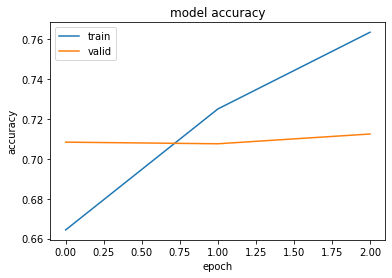

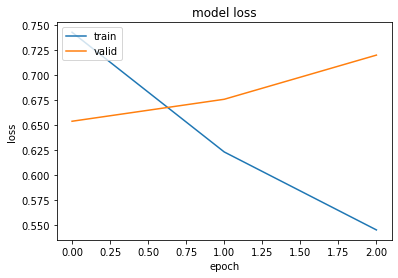

In [ ]:
plot_curves(history)

## Modele DropOut

In [ ]:
input_ids = tensorflow.keras.Input(
    shape=(MAX_LEN,), dtype=tensorflow.int32, name="input_ids"
)
attention_mask = tensorflow.keras.Input(
    shape=(MAX_LEN,), dtype=tensorflow.int32, name="attention_mask"
)

transformer_layer = transformers.TFAutoModel.from_pretrained("../input/distil-bert")

sequence_output = transformer_layer([input_ids, attention_mask])["last_hidden_state"]
clf_output = sequence_output[:, 0, :]

out = multi_sample_drop_out(
    clf_output,
    tensorflow.keras.layers.Dense(256, activation="relu"),
    tensorflow.keras.layers.Dense(3, activation="softmax"),
    5,
)
model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=out)

model.compile(
    tensorflow.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

Some layers from the model checkpoint at ../input/distil-bert were not used when initializing TFDistilBertModel: ['pre_classifier', 'dropout_19', 'classifier']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at ../input/distil-bert.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [ ]:
Stopping_condition = tensorflow.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.03,
    patience=10,
    # mode='max',
    verbose=1,
)

history = model.fit(
    data_train,
    epochs=3,
    # validation_steps = validation_size // batch_size,
    validation_data=data_valid,
    # steps_per_epoch = train_size // batch_size,
    callbacks=[Stopping_condition],
)

Epoch 1/3
1834/1834 [==============================] - 1085s 586ms/step - loss: 0.7369 - accuracy: 0.6664 - val_loss: 0.6729 - val_accuracy: 0.6987
Epoch 2/3
1834/1834 [==============================] - 1074s 586ms/step - loss: 0.6180 - accuracy: 0.7283 - val_loss: 0.6428 - val_accuracy: 0.7178
Epoch 3/3
1834/1834 [==============================] - 1074s 586ms/step - loss: 0.5424 - accuracy: 0.7649 - val_loss: 0.6763 - val_accuracy: 0.7219


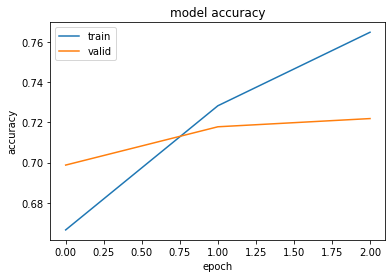

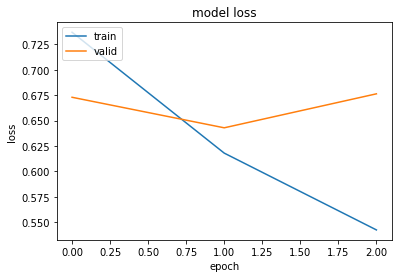

In [ ]:
plot_curves(history)